<a href="https://colab.research.google.com/github/shathahamad/shathahamad/blob/main/thepro2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer

from datetime import datetime, timedelta

import lightgbm as lgb

import warnings # Supress warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/train_data.csv')
display(train_df.head().style.set_caption('Train data'))


test_df = pd.read_csv('/content/drive/MyDrive/test_data.csv')
display(test_df.head().style.set_caption('Test data'))

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,nmme0-tmp2m-34w__gfdl0,nmme0-tmp2m-34w__nasa0,nmme0-tmp2m-34w__nmme0mean,contest-wind-h10-14d__wind-hgt-10,nmme-tmp2m-56w__cancm3,nmme-tmp2m-56w__cancm4,nmme-tmp2m-56w__ccsm3,nmme-tmp2m-56w__ccsm4,nmme-tmp2m-56w__cfsv2,nmme-tmp2m-56w__gfdl,nmme-tmp2m-56w__gfdlflora,nmme-tmp2m-56w__gfdlflorb,nmme-tmp2m-56w__nasa,nmme-tmp2m-56w__nmmemean,contest-rhum-sig995-14d__rhum,nmme-prate-34w__cancm3,nmme-prate-34w__cancm4,nmme-prate-34w__ccsm3,nmme-prate-34w__ccsm4,nmme-prate-34w__cfsv2,nmme-prate-34w__gfdl,nmme-prate-34w__gfdlflora,nmme-prate-34w__gfdlflorb,nmme-prate-34w__nasa,nmme-prate-34w__nmmemean,contest-wind-h100-14d__wind-hgt-100,nmme0-prate-56w__cancm30,nmme0-prate-56w__cancm40,nmme0-prate-56w__ccsm30,nmme0-prate-56w__ccsm40,nmme0-prate-56w__cfsv20,nmme0-prate-56w__gfdlflora0,nmme0-prate-56w__gfdlflorb0,nmme0-prate-56w__gfdl0,nmme0-prate-56w__nasa0,nmme0-prate-56w__nmme0mean,nmme0-prate-34w__cancm30,nmme0-prate-34w__cancm40,nmme0-prate-34w__ccsm30,nmme0-prate-34w__ccsm40,nmme0-prate-34w__cfsv20,nmme0-prate-34w__gfdlflora0,nmme0-prate-34w__gfdlflorb0,nmme0-prate-34w__gfdl0,nmme0-prate-34w__nasa0,nmme0-prate-34w__nmme0mean,contest-tmp2m-14d__tmp2m,contest-slp-14d__slp,contest-wind-vwnd-925-14d__wind-vwnd-925,nmme-prate-56w__cancm3,nmme-prate-56w__cancm4,nmme-prate-56w__ccsm3,nmme-prate-56w__ccsm4,nmme-prate-56w__cfsv2,nmme-prate-56w__gfdl,nmme-prate-56w__gfdlflora,nmme-prate-56w__gfdlflorb,nmme-prate-56w__nasa,nmme-prate-56w__nmmemean,contest-pres-sfc-gauss-14d__pres,contest-wind-uwnd-250-14d__wind-uwnd-250,nmme-tmp2m-34w__cancm3,nmme-tmp2m-34w__cancm4,nmme-tmp2m-34w__ccsm3,nmme-tmp2m-34w__ccsm4,nmme-tmp2m-34w__cfsv2,nmme-tmp2m-34w__gfdl,nmme-tmp2m-34w__gfdlflora,nmme-tmp2m-34w__gfdlflorb,nmme-tmp2m-34w__nasa,nmme-tmp2m-34w__nmmemean,contest-prwtr-eatm-14d__prwtr,contest-wind-vwnd-250-14d__wind-vwnd-250,contest-precip-14d__precip,contest-wind-h850-14d__wind-hgt-850,contest-wind-uwnd-925-14d__wind-uwnd-925,contest-wind-h500-14d__wind-hgt-500,cancm30,cancm40,ccsm30,ccsm40,cfsv20,gfdlflora0,gfdlflorb0,gfdl0,nasa0,nmme0mean,climateregions__climateregion,elevation__elevation,wind-vwnd-250-2010-1,wind-vwnd-250-2010-2,wind-vwnd-250-2010-3,wind-vwnd-250-2010-4,wind-vwnd-250-2010-5,wind-vwnd-250-2010-6,wind-vwnd-250-2010-7,wind-vwnd-250-2010-8,wind-vwnd-250-2010-9,wind-vwnd-250-2010-10,wind-vwnd-250-2010-11,wind-vwnd-250-2010-12,wind-vwnd-250-2010-13,wind-vwnd-250-2010-14,wind-vwnd-250-2010-15,wind-vwnd-250-2010-16,wind-vwnd-250-2010-17,wind-vwnd-250-2010-18,wind-vwnd-250-2010-19,wind-vwnd-250-2010-20,wind-uwnd-250-2010-1,wind-uwnd-250-2010-2,wind-uwnd-250-2010-3,wind-uwnd-250-2010-4,wind-uwnd-250-2010-5,wind-uwnd-250-2010-6,wind-uwnd-250-2010-7,wind-uwnd-250-2010-8,wind-uwnd-250-2010-9,wind-uwnd-250-2010-10,wind-uwnd-250-2010-11,wind-uwnd-250-2010-12,wind-uwnd-250-2010-13,wind-uwnd-250-2010-14,wind-uwnd-250-2010-15,wind-uwnd-250-2010-16,wind-uwnd-250-2010-17,wind-uwnd-250-2010-18,wind-uwnd-250-2010-19,wind-uwnd-250-2010-20,mjo1d__phase,mjo1d__amplitude,mei__mei,mei__meirank,mei__nip,wind-hgt-850-2010-1,wind-hgt-850-2010-2,wind-hgt-850-2010-3,wind-hgt-850-2010-4,wind-hgt-850-2010-5,wind-hgt-850-2010-6,wind-hgt-850-2010-7,wind-hgt-850-2010-8,wind-hgt-850-2010-9,wind-hgt-850-2010-10,sst-2010-1,sst-2010-2,sst-2010-3,sst-2010-4,sst-2010-5,sst-2010-6,sst-2010-7,sst-2010-8,sst-2010-9,sst-2010-10,wind-hgt-500-2010-1,wind-hgt-500-2010-2,wind-hgt-500-2010-3,wind-hgt-500-2010-4,wind-hgt-500-2010-5,wind-hgt-500-2010-6,wind-hgt-500-2010-7,wind-hgt-500-2010-8,wind-hgt-500-2010-9,wind-hgt-500-2010-10,icec-2010-1,icec-2010-2,icec-2010-3,icec-2010-4,icec-2010-5,icec-2010-6,icec-2010-7,icec-2010-8,icec-2010-9,icec-2010-10,wind-uwnd-925-2010-1,wind-uwnd-925-2010-2,wind-uwnd-925-2010-3,wind-uwnd-925-2010-4,wind-uwnd-925-2010

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,nmme0-tmp2m-34w__gfdl0,nmme0-tmp2m-34w__nasa0,nmme0-tmp2m-34w__nmme0mean,contest-wind-h10-14d__wind-hgt-10,nmme-tmp2m-56w__cancm3,nmme-tmp2m-56w__cancm4,nmme-tmp2m-56w__ccsm3,nmme-tmp2m-56w__ccsm4,nmme-tmp2m-56w__cfsv2,nmme-tmp2m-56w__gfdl,nmme-tmp2m-56w__gfdlflora,nmme-tmp2m-56w__gfdlflorb,nmme-tmp2m-56w__nasa,nmme-tmp2m-56w__nmmemean,contest-rhum-sig995-14d__rhum,nmme-prate-34w__cancm3,nmme-prate-34w__cancm4,nmme-prate-34w__ccsm3,nmme-prate-34w__ccsm4,nmme-prate-34w__cfsv2,nmme-prate-34w__gfdl,nmme-prate-34w__gfdlflora,nmme-prate-34w__gfdlflorb,nmme-prate-34w__nasa,nmme-prate-34w__nmmemean,contest-wind-h100-14d__wind-hgt-100,nmme0-prate-56w__cancm30,nmme0-prate-56w__cancm40,nmme0-prate-56w__ccsm30,nmme0-prate-56w__ccsm40,nmme0-prate-56w__cfsv20,nmme0-prate-56w__gfdlflora0,nmme0-prate-56w__gfdlflorb0,nmme0-prate-56w__gfdl0,nmme0-prate-56w__nasa0,nmme0-prate-56w__nmme0mean,nmme0-prate-34w__cancm30,nmme0-prate-34w__cancm40,nmme0-prate-34w__ccsm30,nmme0-prate-34w__ccsm40,nmme0-prate-34w__cfsv20,nmme0-prate-34w__gfdlflora0,nmme0-prate-34w__gfdlflorb0,nmme0-prate-34w__gfdl0,nmme0-prate-34w__nasa0,nmme0-prate-34w__nmme0mean,contest-slp-14d__slp,contest-wind-vwnd-925-14d__wind-vwnd-925,nmme-prate-56w__cancm3,nmme-prate-56w__cancm4,nmme-prate-56w__ccsm3,nmme-prate-56w__ccsm4,nmme-prate-56w__cfsv2,nmme-prate-56w__gfdl,nmme-prate-56w__gfdlflora,nmme-prate-56w__gfdlflorb,nmme-prate-56w__nasa,nmme-prate-56w__nmmemean,contest-pres-sfc-gauss-14d__pres,contest-wind-uwnd-250-14d__wind-uwnd-250,nmme-tmp2m-34w__cancm3,nmme-tmp2m-34w__cancm4,nmme-tmp2m-34w__ccsm3,nmme-tmp2m-34w__ccsm4,nmme-tmp2m-34w__cfsv2,nmme-tmp2m-34w__gfdl,nmme-tmp2m-34w__gfdlflora,nmme-tmp2m-34w__gfdlflorb,nmme-tmp2m-34w__nasa,nmme-tmp2m-34w__nmmemean,contest-prwtr-eatm-14d__prwtr,contest-wind-vwnd-250-14d__wind-vwnd-250,contest-precip-14d__precip,contest-wind-h850-14d__wind-hgt-850,contest-wind-uwnd-925-14d__wind-uwnd-925,contest-wind-h500-14d__wind-hgt-500,cancm30,cancm40,ccsm30,ccsm40,cfsv20,gfdlflora0,gfdlflorb0,gfdl0,nasa0,nmme0mean,climateregions__climateregion,elevation__elevation,wind-vwnd-250-2010-1,wind-vwnd-250-2010-2,wind-vwnd-250-2010-3,wind-vwnd-250-2010-4,wind-vwnd-250-2010-5,wind-vwnd-250-2010-6,wind-vwnd-250-2010-7,wind-vwnd-250-2010-8,wind-vwnd-250-2010-9,wind-vwnd-250-2010-10,wind-vwnd-250-2010-11,wind-vwnd-250-2010-12,wind-vwnd-250-2010-13,wind-vwnd-250-2010-14,wind-vwnd-250-2010-15,wind-vwnd-250-2010-16,wind-vwnd-250-2010-17,wind-vwnd-250-2010-18,wind-vwnd-250-2010-19,wind-vwnd-250-2010-20,wind-uwnd-250-2010-1,wind-uwnd-250-2010-2,wind-uwnd-250-2010-3,wind-uwnd-250-2010-4,wind-uwnd-250-2010-5,wind-uwnd-250-2010-6,wind-uwnd-250-2010-7,wind-uwnd-250-2010-8,wind-uwnd-250-2010-9,wind-uwnd-250-2010-10,wind-uwnd-250-2010-11,wind-uwnd-250-2010-12,wind-uwnd-250-2010-13,wind-uwnd-250-2010-14,wind-uwnd-250-2010-15,wind-uwnd-250-2010-16,wind-uwnd-250-2010-17,wind-uwnd-250-2010-18,wind-uwnd-250-2010-19,wind-uwnd-250-2010-20,mjo1d__phase,mjo1d__amplitude,mei__mei,mei__meirank,mei__nip,wind-hgt-850-2010-1,wind-hgt-850-2010-2,wind-hgt-850-2010-3,wind-hgt-850-2010-4,wind-hgt-850-2010-5,wind-hgt-850-2010-6,wind-hgt-850-2010-7,wind-hgt-850-2010-8,wind-hgt-850-2010-9,wind-hgt-850-2010-10,sst-2010-1,sst-2010-2,sst-2010-3,sst-2010-4,sst-2010-5,sst-2010-6,sst-2010-7,sst-2010-8,sst-2010-9,sst-2010-10,wind-hgt-500-2010-1,wind-hgt-500-2010-2,wind-hgt-500-2010-3,wind-hgt-500-2010-4,wind-hgt-500-2010-5,wind-hgt-500-2010-6,wind-hgt-500-2010-7,wind-hgt-500-2010-8,wind-hgt-500-2010-9,wind-hgt-500-2010-10,icec-2010-1,icec-2010-2,icec-2010-3,icec-2010-4,icec-2010-5,icec-2010-6,icec-2010-7,icec-2010-8,icec-2010-9,icec-2010-10,wind-uwnd-925-2010-1,wind-uwnd-925-2010-2,wind-uwnd-925-2010-3,wind-uwnd-925-2010-4,wind-uwnd-925-2010-5,wind-uwnd-925-2010-6,w

In [ ]:
target = [c for c in train_df.columns if c not in test_df.columns][0]
print(target)

contest-tmp2m-14d__tmp2m


In [ ]:
train_df.startdate = pd.to_datetime(train_df.startdate)
test_df.startdate = pd.to_datetime(test_df.startdate)

In [ ]:
display(train_df.head().style.set_caption('Train data'))

display(test_df.head().style.set_caption('Test data'))

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,nmme0-tmp2m-34w__gfdl0,nmme0-tmp2m-34w__nasa0,nmme0-tmp2m-34w__nmme0mean,contest-wind-h10-14d__wind-hgt-10,nmme-tmp2m-56w__cancm3,nmme-tmp2m-56w__cancm4,nmme-tmp2m-56w__ccsm3,nmme-tmp2m-56w__ccsm4,nmme-tmp2m-56w__cfsv2,nmme-tmp2m-56w__gfdl,nmme-tmp2m-56w__gfdlflora,nmme-tmp2m-56w__gfdlflorb,nmme-tmp2m-56w__nasa,nmme-tmp2m-56w__nmmemean,contest-rhum-sig995-14d__rhum,nmme-prate-34w__cancm3,nmme-prate-34w__cancm4,nmme-prate-34w__ccsm3,nmme-prate-34w__ccsm4,nmme-prate-34w__cfsv2,nmme-prate-34w__gfdl,nmme-prate-34w__gfdlflora,nmme-prate-34w__gfdlflorb,nmme-prate-34w__nasa,nmme-prate-34w__nmmemean,contest-wind-h100-14d__wind-hgt-100,nmme0-prate-56w__cancm30,nmme0-prate-56w__cancm40,nmme0-prate-56w__ccsm30,nmme0-prate-56w__ccsm40,nmme0-prate-56w__cfsv20,nmme0-prate-56w__gfdlflora0,nmme0-prate-56w__gfdlflorb0,nmme0-prate-56w__gfdl0,nmme0-prate-56w__nasa0,nmme0-prate-56w__nmme0mean,nmme0-prate-34w__cancm30,nmme0-prate-34w__cancm40,nmme0-prate-34w__ccsm30,nmme0-prate-34w__ccsm40,nmme0-prate-34w__cfsv20,nmme0-prate-34w__gfdlflora0,nmme0-prate-34w__gfdlflorb0,nmme0-prate-34w__gfdl0,nmme0-prate-34w__nasa0,nmme0-prate-34w__nmme0mean,contest-tmp2m-14d__tmp2m,contest-slp-14d__slp,contest-wind-vwnd-925-14d__wind-vwnd-925,nmme-prate-56w__cancm3,nmme-prate-56w__cancm4,nmme-prate-56w__ccsm3,nmme-prate-56w__ccsm4,nmme-prate-56w__cfsv2,nmme-prate-56w__gfdl,nmme-prate-56w__gfdlflora,nmme-prate-56w__gfdlflorb,nmme-prate-56w__nasa,nmme-prate-56w__nmmemean,contest-pres-sfc-gauss-14d__pres,contest-wind-uwnd-250-14d__wind-uwnd-250,nmme-tmp2m-34w__cancm3,nmme-tmp2m-34w__cancm4,nmme-tmp2m-34w__ccsm3,nmme-tmp2m-34w__ccsm4,nmme-tmp2m-34w__cfsv2,nmme-tmp2m-34w__gfdl,nmme-tmp2m-34w__gfdlflora,nmme-tmp2m-34w__gfdlflorb,nmme-tmp2m-34w__nasa,nmme-tmp2m-34w__nmmemean,contest-prwtr-eatm-14d__prwtr,contest-wind-vwnd-250-14d__wind-vwnd-250,contest-precip-14d__precip,contest-wind-h850-14d__wind-hgt-850,contest-wind-uwnd-925-14d__wind-uwnd-925,contest-wind-h500-14d__wind-hgt-500,cancm30,cancm40,ccsm30,ccsm40,cfsv20,gfdlflora0,gfdlflorb0,gfdl0,nasa0,nmme0mean,climateregions__climateregion,elevation__elevation,wind-vwnd-250-2010-1,wind-vwnd-250-2010-2,wind-vwnd-250-2010-3,wind-vwnd-250-2010-4,wind-vwnd-250-2010-5,wind-vwnd-250-2010-6,wind-vwnd-250-2010-7,wind-vwnd-250-2010-8,wind-vwnd-250-2010-9,wind-vwnd-250-2010-10,wind-vwnd-250-2010-11,wind-vwnd-250-2010-12,wind-vwnd-250-2010-13,wind-vwnd-250-2010-14,wind-vwnd-250-2010-15,wind-vwnd-250-2010-16,wind-vwnd-250-2010-17,wind-vwnd-250-2010-18,wind-vwnd-250-2010-19,wind-vwnd-250-2010-20,wind-uwnd-250-2010-1,wind-uwnd-250-2010-2,wind-uwnd-250-2010-3,wind-uwnd-250-2010-4,wind-uwnd-250-2010-5,wind-uwnd-250-2010-6,wind-uwnd-250-2010-7,wind-uwnd-250-2010-8,wind-uwnd-250-2010-9,wind-uwnd-250-2010-10,wind-uwnd-250-2010-11,wind-uwnd-250-2010-12,wind-uwnd-250-2010-13,wind-uwnd-250-2010-14,wind-uwnd-250-2010-15,wind-uwnd-250-2010-16,wind-uwnd-250-2010-17,wind-uwnd-250-2010-18,wind-uwnd-250-2010-19,wind-uwnd-250-2010-20,mjo1d__phase,mjo1d__amplitude,mei__mei,mei__meirank,mei__nip,wind-hgt-850-2010-1,wind-hgt-850-2010-2,wind-hgt-850-2010-3,wind-hgt-850-2010-4,wind-hgt-850-2010-5,wind-hgt-850-2010-6,wind-hgt-850-2010-7,wind-hgt-850-2010-8,wind-hgt-850-2010-9,wind-hgt-850-2010-10,sst-2010-1,sst-2010-2,sst-2010-3,sst-2010-4,sst-2010-5,sst-2010-6,sst-2010-7,sst-2010-8,sst-2010-9,sst-2010-10,wind-hgt-500-2010-1,wind-hgt-500-2010-2,wind-hgt-500-2010-3,wind-hgt-500-2010-4,wind-hgt-500-2010-5,wind-hgt-500-2010-6,wind-hgt-500-2010-7,wind-hgt-500-2010-8,wind-hgt-500-2010-9,wind-hgt-500-2010-10,icec-2010-1,icec-2010-2,icec-2010-3,icec-2010-4,icec-2010-5,icec-2010-6,icec-2010-7,icec-2010-8,icec-2010-9,icec-2010-10,wind-uwnd-925-2010-1,wind-uwnd-925-2010-2,wind-uwnd-925-2010-3,wind-uwnd-925-2010-4,wind-uwnd-925-2010

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,nmme0-tmp2m-34w__gfdl0,nmme0-tmp2m-34w__nasa0,nmme0-tmp2m-34w__nmme0mean,contest-wind-h10-14d__wind-hgt-10,nmme-tmp2m-56w__cancm3,nmme-tmp2m-56w__cancm4,nmme-tmp2m-56w__ccsm3,nmme-tmp2m-56w__ccsm4,nmme-tmp2m-56w__cfsv2,nmme-tmp2m-56w__gfdl,nmme-tmp2m-56w__gfdlflora,nmme-tmp2m-56w__gfdlflorb,nmme-tmp2m-56w__nasa,nmme-tmp2m-56w__nmmemean,contest-rhum-sig995-14d__rhum,nmme-prate-34w__cancm3,nmme-prate-34w__cancm4,nmme-prate-34w__ccsm3,nmme-prate-34w__ccsm4,nmme-prate-34w__cfsv2,nmme-prate-34w__gfdl,nmme-prate-34w__gfdlflora,nmme-prate-34w__gfdlflorb,nmme-prate-34w__nasa,nmme-prate-34w__nmmemean,contest-wind-h100-14d__wind-hgt-100,nmme0-prate-56w__cancm30,nmme0-prate-56w__cancm40,nmme0-prate-56w__ccsm30,nmme0-prate-56w__ccsm40,nmme0-prate-56w__cfsv20,nmme0-prate-56w__gfdlflora0,nmme0-prate-56w__gfdlflorb0,nmme0-prate-56w__gfdl0,nmme0-prate-56w__nasa0,nmme0-prate-56w__nmme0mean,nmme0-prate-34w__cancm30,nmme0-prate-34w__cancm40,nmme0-prate-34w__ccsm30,nmme0-prate-34w__ccsm40,nmme0-prate-34w__cfsv20,nmme0-prate-34w__gfdlflora0,nmme0-prate-34w__gfdlflorb0,nmme0-prate-34w__gfdl0,nmme0-prate-34w__nasa0,nmme0-prate-34w__nmme0mean,contest-slp-14d__slp,contest-wind-vwnd-925-14d__wind-vwnd-925,nmme-prate-56w__cancm3,nmme-prate-56w__cancm4,nmme-prate-56w__ccsm3,nmme-prate-56w__ccsm4,nmme-prate-56w__cfsv2,nmme-prate-56w__gfdl,nmme-prate-56w__gfdlflora,nmme-prate-56w__gfdlflorb,nmme-prate-56w__nasa,nmme-prate-56w__nmmemean,contest-pres-sfc-gauss-14d__pres,contest-wind-uwnd-250-14d__wind-uwnd-250,nmme-tmp2m-34w__cancm3,nmme-tmp2m-34w__cancm4,nmme-tmp2m-34w__ccsm3,nmme-tmp2m-34w__ccsm4,nmme-tmp2m-34w__cfsv2,nmme-tmp2m-34w__gfdl,nmme-tmp2m-34w__gfdlflora,nmme-tmp2m-34w__gfdlflorb,nmme-tmp2m-34w__nasa,nmme-tmp2m-34w__nmmemean,contest-prwtr-eatm-14d__prwtr,contest-wind-vwnd-250-14d__wind-vwnd-250,contest-precip-14d__precip,contest-wind-h850-14d__wind-hgt-850,contest-wind-uwnd-925-14d__wind-uwnd-925,contest-wind-h500-14d__wind-hgt-500,cancm30,cancm40,ccsm30,ccsm40,cfsv20,gfdlflora0,gfdlflorb0,gfdl0,nasa0,nmme0mean,climateregions__climateregion,elevation__elevation,wind-vwnd-250-2010-1,wind-vwnd-250-2010-2,wind-vwnd-250-2010-3,wind-vwnd-250-2010-4,wind-vwnd-250-2010-5,wind-vwnd-250-2010-6,wind-vwnd-250-2010-7,wind-vwnd-250-2010-8,wind-vwnd-250-2010-9,wind-vwnd-250-2010-10,wind-vwnd-250-2010-11,wind-vwnd-250-2010-12,wind-vwnd-250-2010-13,wind-vwnd-250-2010-14,wind-vwnd-250-2010-15,wind-vwnd-250-2010-16,wind-vwnd-250-2010-17,wind-vwnd-250-2010-18,wind-vwnd-250-2010-19,wind-vwnd-250-2010-20,wind-uwnd-250-2010-1,wind-uwnd-250-2010-2,wind-uwnd-250-2010-3,wind-uwnd-250-2010-4,wind-uwnd-250-2010-5,wind-uwnd-250-2010-6,wind-uwnd-250-2010-7,wind-uwnd-250-2010-8,wind-uwnd-250-2010-9,wind-uwnd-250-2010-10,wind-uwnd-250-2010-11,wind-uwnd-250-2010-12,wind-uwnd-250-2010-13,wind-uwnd-250-2010-14,wind-uwnd-250-2010-15,wind-uwnd-250-2010-16,wind-uwnd-250-2010-17,wind-uwnd-250-2010-18,wind-uwnd-250-2010-19,wind-uwnd-250-2010-20,mjo1d__phase,mjo1d__amplitude,mei__mei,mei__meirank,mei__nip,wind-hgt-850-2010-1,wind-hgt-850-2010-2,wind-hgt-850-2010-3,wind-hgt-850-2010-4,wind-hgt-850-2010-5,wind-hgt-850-2010-6,wind-hgt-850-2010-7,wind-hgt-850-2010-8,wind-hgt-850-2010-9,wind-hgt-850-2010-10,sst-2010-1,sst-2010-2,sst-2010-3,sst-2010-4,sst-2010-5,sst-2010-6,sst-2010-7,sst-2010-8,sst-2010-9,sst-2010-10,wind-hgt-500-2010-1,wind-hgt-500-2010-2,wind-hgt-500-2010-3,wind-hgt-500-2010-4,wind-hgt-500-2010-5,wind-hgt-500-2010-6,wind-hgt-500-2010-7,wind-hgt-500-2010-8,wind-hgt-500-2010-9,wind-hgt-500-2010-10,icec-2010-1,icec-2010-2,icec-2010-3,icec-2010-4,icec-2010-5,icec-2010-6,icec-2010-7,icec-2010-8,icec-2010-9,icec-2010-10,wind-uwnd-925-2010-1,wind-uwnd-925-2010-2,wind-uwnd-925-2010-3,wind-uwnd-925-2010-4,wind-uwnd-925-2010-5,wind-uwnd-925-2010-6,w

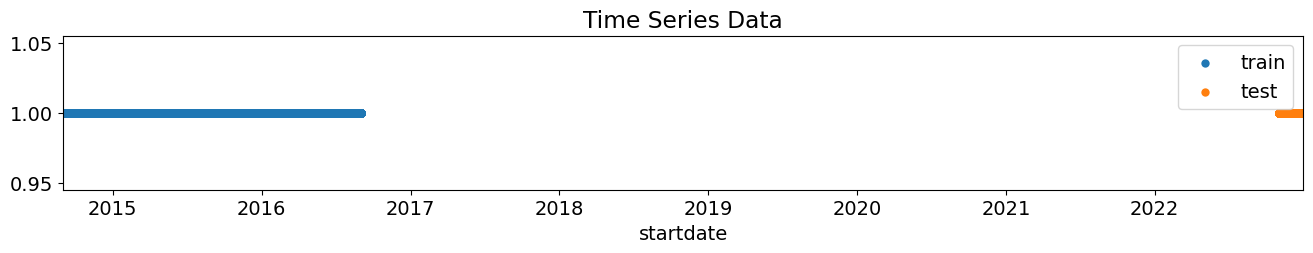

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(16,2))
ax.set_title('Time Series Data')
sns.scatterplot(data = train_df, x = 'startdate', y = 1, marker='o', linewidth=0, label = 'train')
sns.scatterplot(data = test_df, x = 'startdate', y = 1, marker='o', linewidth=0, label = 'test')
ax.set_xlim([train_df['startdate'].iloc[0], test_df['startdate'].iloc[-1]])
plt.show()

In [ ]:
train_df.groupby('startdate')[target].count()

startdate
2014-09-01    514
2014-09-02    514
2014-09-03    514
2014-09-04    514
2014-09-05    514
             ... 
2016-08-27    514
2016-08-28    514
2016-08-29    514
2016-08-30    514
2016-08-31    514
Name: contest-tmp2m-14d__tmp2m, Length: 731, dtype: int64

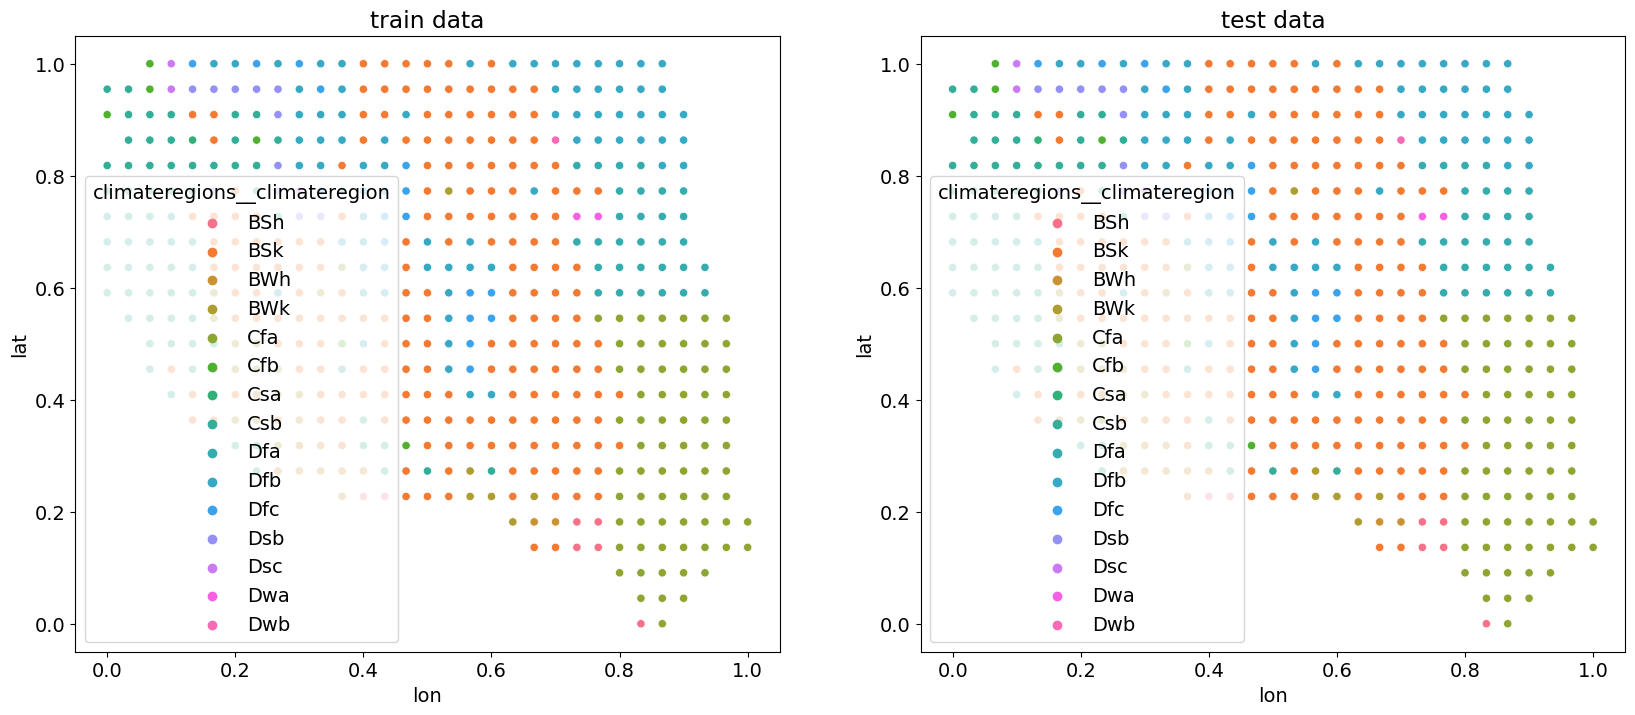

In [ ]:
temp = train_df.groupby(['climateregions__climateregion', 'lat', 'lon']).size().to_frame().reset_index(drop=False)
fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.scatterplot(data=temp, y='lat', x='lon', hue='climateregions__climateregion', ax=ax[0])
ax[0].set_title('train data')
temp = test_df.groupby(['climateregions__climateregion', 'lat', 'lon']).size().to_frame().reset_index(drop=False)
sns.scatterplot(data=temp, y='lat', x='lon', hue='climateregions__climateregion', ax=ax[1])
ax[1].set_title('test data')
plt.show()

In [ ]:
# Concatenate train and test data
all_df = pd.concat([train_df, test_df], axis=0)

# Create new feature
all_df['loc_group'] = all_df.groupby(['lat','lon']).ngroup()
display(all_df)

print(f'{all_df.loc_group.nunique()} unique locations')

# Split back up
train_df = all_df.iloc[:len(train_df)]
test_df = all_df.iloc[len(train_df):]

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20,loc_group
0,0,0.0,0.833333,2014-09-01,237.00,29.02,31.64,29.57,30.73,29.71,...,-37.21,8.32,9.56,-2.03,48.13,28.09,-13.50,11.90,4.58,0
1,1,0.0,0.833333,2014-09-02,228.90,29.02,31.64,29.57,30.73,29.71,...,-36.57,8.77,21.17,4.44,48.60,27.41,-23.77,15.44,3.42,0
2,2,0.0,0.833333,2014-09-03,220.69,29.02,31.64,29.57,30.73,29.71,...,-34.16,6.99,32.16,5.01,48.53,19.21,-33.16,15.11,4.82,0
3,3,0.0,0.833333,2014-09-04,225.28,29.02,31.64,29.57,30.73,29.71,...,-31.04,6.17,39.66,-1.41,50.59,8.29,-37.22,18.24,9.74,0
4,4,0.0,0.833333,2014-09-05,237.24,29.02,31.64,29.57,30.73,29.71,...,-31.80,7.47,38.62,-5.21,54.73,-2.58,-42.30,21.91,10.95,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31349,407083,1.0,0.866667,2022-12-27,62.72,4.60,8.71,6.05,10.08,6.39,...,-8.49,32.39,38.82,7.42,11.75,-23.62,-0.24,-5.94,51.23,574
31350,407084,1.0,0.866667,2022-12-28,73.41,4.60,8.71,6.05,10.08,6.39,...,0.83,26.23,37.64,13.01,17.84,-22.05,-3.03,1.31,51.45,574
31351,407085,1.0,0.866667,2022-12-29,70.00,4.60,8.71,6.05,10.08,6.39,...,10.90,21.06,36.53,14.15,23.12,-25.60,-5.88,9.32,45.32,574
31352,407086,1.0,0.866667,2022-12-30,79.81,4.60,8.71,6.05,10.08,6.39,...,21.37,20.42,36.05,6.38,29.00,-27.06,-1.42,16.06,31.88,574


575 unique locations


In [ ]:
print('Locations in train that are not in test')
print([c for c in train_df.loc_group.unique() if c not in test_df.loc_group.unique()])

print('Locations in test that are not in train')
print([c for c in test_df.loc_group.unique() if c not in train_df.loc_group.unique()])

Locations in train that are not in test
[33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 76, 101, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 181, 210, 239, 269, 300, 330, 360, 389, 418, 447, 475, 504, 533, 559]
Locations in test that are not in train
[52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 75, 100, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 180, 209, 238, 268, 299, 329, 359, 388, 417, 446, 474, 503, 532, 558]


In [ ]:
scale = 14

train_df.loc[:,'lat']=round(train_df.lat,scale)
train_df.loc[:,'lon']=round(train_df.lon,scale)

test_df.loc[:,'lat']=round(test_df.lat,scale)
test_df.loc[:,'lon']=round(test_df.lon,scale)

# Concatenate train and test data
all_df = pd.concat([train_df, test_df], axis=0)

# Create new feature
all_df['loc_group'] = all_df.groupby(['lat','lon']).ngroup()
display(all_df)

print(f'{all_df.loc_group.nunique()} unique locations')

# Split back up
train_df = all_df.iloc[:len(train_df)]
test_df = all_df.iloc[len(train_df):]

print('Locations in train that are not in test')
print([c for c in train_df.loc_group.unique() if c not in test_df.loc_group.unique()])

print('Locations in test that are not in train')
print([c for c in test_df.loc_group.unique() if c not in train_df.loc_group.unique()])

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20,loc_group
0,0,0.0,0.833333,2014-09-01,237.00,29.02,31.64,29.57,30.73,29.71,...,-37.21,8.32,9.56,-2.03,48.13,28.09,-13.50,11.90,4.58,0
1,1,0.0,0.833333,2014-09-02,228.90,29.02,31.64,29.57,30.73,29.71,...,-36.57,8.77,21.17,4.44,48.60,27.41,-23.77,15.44,3.42,0
2,2,0.0,0.833333,2014-09-03,220.69,29.02,31.64,29.57,30.73,29.71,...,-34.16,6.99,32.16,5.01,48.53,19.21,-33.16,15.11,4.82,0
3,3,0.0,0.833333,2014-09-04,225.28,29.02,31.64,29.57,30.73,29.71,...,-31.04,6.17,39.66,-1.41,50.59,8.29,-37.22,18.24,9.74,0
4,4,0.0,0.833333,2014-09-05,237.24,29.02,31.64,29.57,30.73,29.71,...,-31.80,7.47,38.62,-5.21,54.73,-2.58,-42.30,21.91,10.95,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31349,407083,1.0,0.866667,2022-12-27,62.72,4.60,8.71,6.05,10.08,6.39,...,-8.49,32.39,38.82,7.42,11.75,-23.62,-0.24,-5.94,51.23,513
31350,407084,1.0,0.866667,2022-12-28,73.41,4.60,8.71,6.05,10.08,6.39,...,0.83,26.23,37.64,13.01,17.84,-22.05,-3.03,1.31,51.45,513
31351,407085,1.0,0.866667,2022-12-29,70.00,4.60,8.71,6.05,10.08,6.39,...,10.90,21.06,36.53,14.15,23.12,-25.60,-5.88,9.32,45.32,513
31352,407086,1.0,0.866667,2022-12-30,79.81,4.60,8.71,6.05,10.08,6.39,...,21.37,20.42,36.05,6.38,29.00,-27.06,-1.42,16.06,31.88,513


514 unique locations
Locations in train that are not in test
[]
Locations in test that are not in train
[]


<Axes: xlabel='startdate', ylabel='contest-tmp2m-14d__tmp2m'>

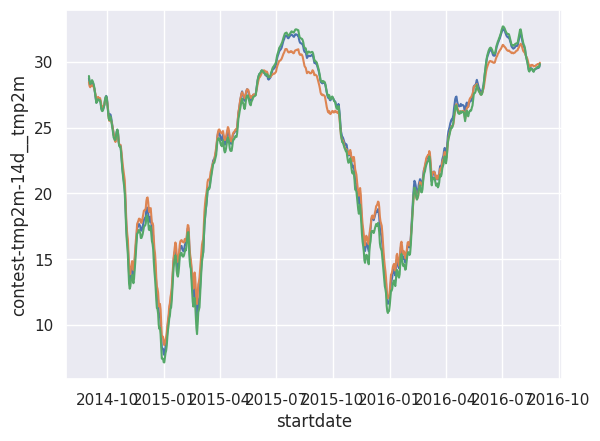

In [ ]:
temp = train_df[train_df.loc_group == 0]
sns.lineplot(data=temp, x = 'startdate', y = target)

temp = train_df[train_df.loc_group == 1]
sns.lineplot(data=temp, x = 'startdate', y = target)

temp = train_df[train_df.loc_group == 2]
sns.lineplot(data=temp, x = 'startdate', y = target)


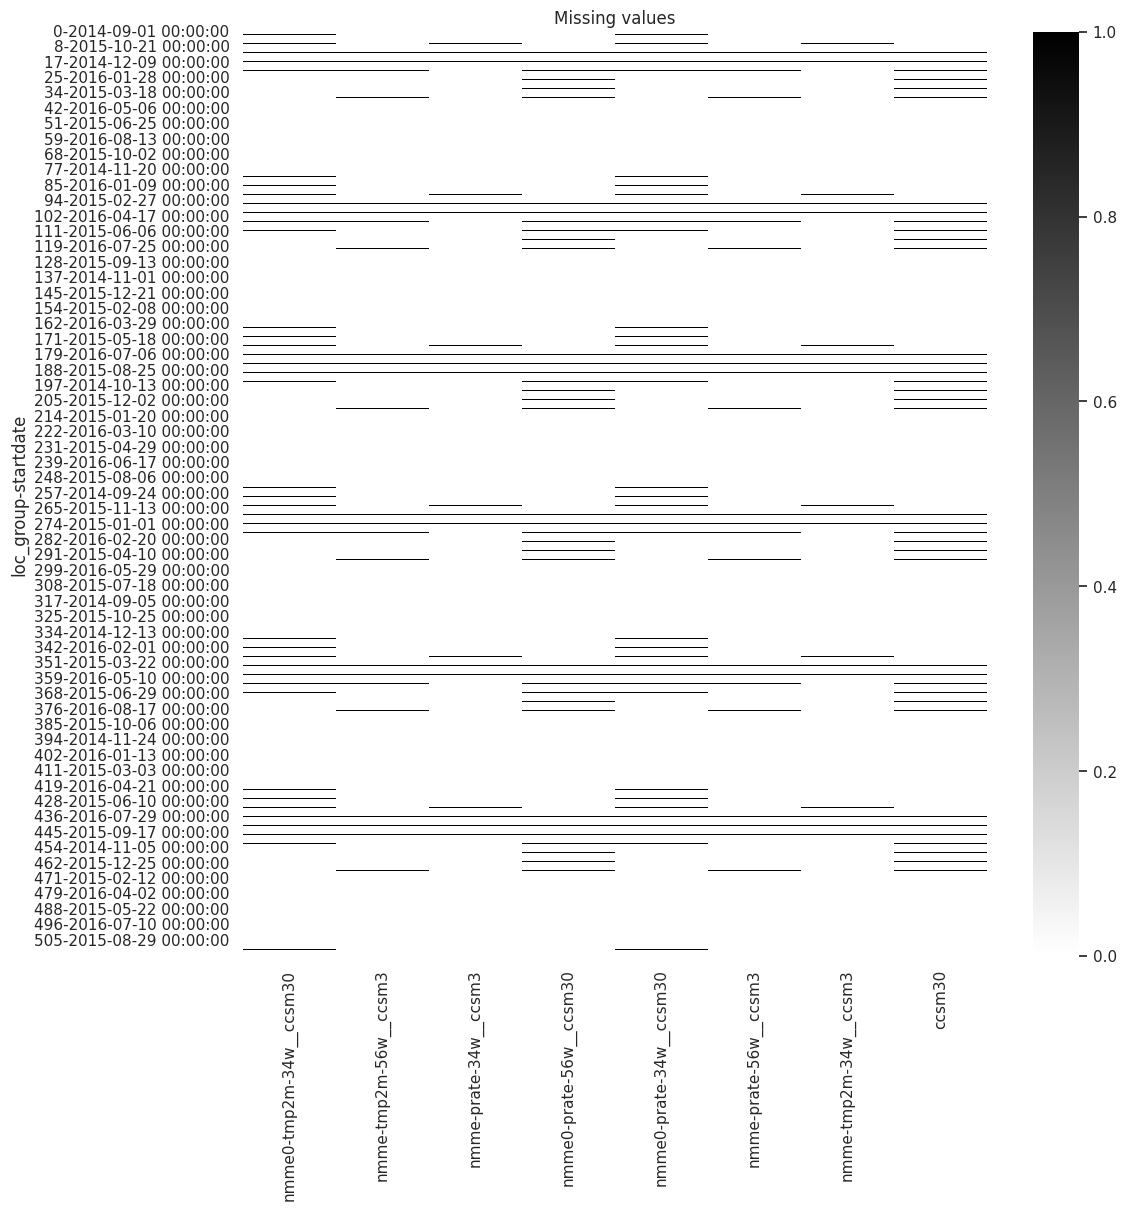

In [ ]:
cols_with_missing = list(train_df.isnull().sum(axis=0)[train_df.isnull().sum(axis=0) > 0].index)

fig, ax = plt.subplots(1,1,figsize=(12,12))
sns.heatmap(train_df.set_index([ 'loc_group', 'startdate'])[cols_with_missing].isnull(), cmap='binary')
ax.set_title('Missing values')
plt.show()

In [ ]:
# Save this for visualization purposes only and delete later
train_df_old = train_df.copy()
train_df_mean = train_df.sort_values(by=['loc_group', 'startdate']).fillna(20)

In [ ]:
train_df = train_df.sort_values(by=['loc_group', 'startdate']).ffill()

In [ ]:
le = preprocessing.LabelEncoder()
train_df['climateregions__climateregion'] = le.fit_transform(train_df['climateregions__climateregion'])
test_df['climateregions__climateregion'] = le.transform(test_df['climateregions__climateregion'])

In [ ]:
def create_time_features(df):
    df = df.copy()
    #df['year'] = df.startdate.dt.year
    df['quarter'] = df.startdate.dt.quarter
    df['month'] = df.startdate.dt.month
    df['week'] = df.startdate.dt.weekofyear
    df['dayofyear'] = df.startdate.dt.day_of_year
    return df

train_df = create_time_features(train_df)
test_df = create_time_features(test_df)
train_df.head()

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20,loc_group,quarter,month,week,dayofyear
0,0,0.0,0.833333,2014-09-01,237.00,29.02,31.64,29.57,30.73,29.71,...,48.13,28.09,-13.50,11.90,4.58,0,3,9,36,244
1,1,0.0,0.833333,2014-09-02,228.90,29.02,31.64,29.57,30.73,29.71,...,48.60,27.41,-23.77,15.44,3.42,0,3,9,36,245
2,2,0.0,0.833333,2014-09-03,220.69,29.02,31.64,29.57,30.73,29.71,...,48.53,19.21,-33.16,15.11,4.82,0,3,9,36,246
3,3,0.0,0.833333,2014-09-04,225.28,29.02,31.64,29.57,30.73,29.71,...,50.59,8.29,-37.22,18.24,9.74,0,3,9,36,247
4,4,0.0,0.833333,2014-09-05,237.24,29.02,31.64,29.57,30.73,29.71,...,54.73,-2.58,-42.30,21.91,10.95,0,3,9,36,248


In [ ]:
def add_season(df):
    month_to_season = {
      1: 0,
      2: 0,
      3: 1,
      4: 1,
      5: 1,
      6: 2,
      7: 2,
      8: 2,
      9: 3,
      10: 3,
      11: 3,
      12: 0
  }
    df['season'] = df['month'].apply(lambda x: month_to_season[x])

add_season(train_df)
add_season(test_df)

In [ ]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

def encode_cyclical(df):
    # encode the day with a period of 365
    df['day_of_year_sin'] = sin_transformer(365).fit_transform(df['dayofyear'])
    df['day_of_year_cos'] = cos_transformer(365).fit_transform(df['dayofyear'])

    # encode the week with a period of 52
    df['week_sin'] = sin_transformer(52).fit_transform(df['week'])
    df['week_cos'] = cos_transformer(52).fit_transform(df['week'])

    # encode the month with a period of 12
    df['month_sin'] = sin_transformer(12).fit_transform(df['month'])
    df['month_cos'] = cos_transformer(12).fit_transform(df['month'])

    # encode the season with a period of 4
    df['season_sin'] = sin_transformer(4).fit_transform(df['season'])
    df['season_cos'] = cos_transformer(4).fit_transform(df['season'])

    # encode the quarter with a period of 4
    df['quarter_sin'] = sin_transformer(4).fit_transform(df['quarter'])
    df['quarter_cos'] = cos_transformer(4).fit_transform(df['quarter'])

encode_cyclical(train_df)
encode_cyclical(test_df)

#train_df.head()
#test_df.head()
#print(train_df)




NameError: ignored

In [ ]:


# Get unique loc_group values
loc_groups = train_df['loc_group'].unique()

# Loop through each loc_group and create a line plot
for loc_group in loc_groups:
    temp = train_df[train_df['loc_group'] == loc_group]
    sns.lineplot(data=temp, x='startdate', y=target, label=f'loc_group {loc_group}')

# Show legend
plt.legend(title='Loc Groups')
plt.show()


NameError: ignored